## 정확도(Accuracy)

In [4]:
from sklearn.base import BaseEstimator

In [5]:
class MyDummyClassifier(BaseEstimator):
    # fit()은 아무것도 학습하지 않음
    def fit(self, X, y=None):
        pass
    
    # predict() 단순히 Sex 1이면 0, 그렇지 않으면 1로 예측
    def predict(self, X):
        pred = np.zeros((X.shape[0], 1))
        for i in range(X.shape[0]) :
            if X['Sex'].iloc[i] == 1:
                pred[i] = 0
            else:
                pred[i] = 1
                
        return pred

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

In [7]:
def fillna(df):
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    df['Cabin'].fillna('N', inplace=True)
    df['Embarked'].fillna('N', inplace=True)
    df['Fare'].fillna(0, inplace=True)
    return df

def drop_features(df):
    df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
    return df

def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin', 'Sex', 'Embarked']
    
    for feature in features:
        le = LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

In [8]:
titanic_df = pd.read_csv('./data/titanic_train.csv')

y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df)
X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.2, random_state=0)

myclf = MyDummyClassifier()
myclf.fit(X_train, y_train)

mypredictions = myclf.predict(X_test)
print(f'Dummy Classifier 정확도: {accuracy_score(y_test, mypredictions):.4f}')

Dummy Classifier 정확도: 0.7877


In [9]:
from sklearn.datasets import load_digits
from sklearn.base import BaseEstimator

class MyFakeClassifier(BaseEstimator):
    
    def fit(self, X, y):
        pass
    
    # 입력값으로 돌어오는 X 데이터 세트의 크기만큼 모두 0값으로 만들어서 반환
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [10]:
digits = load_digits()
y = (digits.target == 7).astype(int)
X_train, X_test, y_train, y_test = train_test_split(digits.data, y, random_state=11)

print('label test set size:', y_test.shape)
print('test set distribution')
print(pd.Series(y_test).value_counts())

fakeclf = MyFakeClassifier()
fakeclf.fit(X_train, y_train)
fakepred = fakeclf.predict(X_test)
print(f'모든 예측을 0으로 하여도 정확도는:{accuracy_score(y_test, fakepred):.3f}')

label test set size: (450,)
test set distribution
0    405
1     45
dtype: int64
모든 예측을 0으로 하여도 정확도는:0.900


## 오차행렬

In [11]:
from sklearn.metrics import confusion_matrix

In [12]:
# MyFakeClassfier 예측 결과인 fakepred 사용
confusion_matrix(y_test, fakepred)

array([[405,   0],
       [ 45,   0]], dtype=int64)

$정확도=\frac{TN+TP}{TN+FP+FN+TP}$
- 정확도는 분류(Classification) 모델 성능의 한 가지 요소
- 불균형한 데이터 세트에서는 모델 신뢰도가 떨어질 수 있음

## 정밀도와 재현율

- $정밀도=\frac{TP}{FP+TP}$
 - 예측을 Positive로 한 대상 중에 예측과 실제 값이 Positive로 일치한 데이터의 비율
 - 양성 예측도
 - 실제 Negative인 데이터 예측을 Positive로 잘못 판단하게 되면 업무상 큰 영향이 발생하는 경우 중요
 
- $재현율=\frac{TP}{FN+TP}$
 - 실제 값이 Positive인 대상 중에 예측과 실제 값이 Positive로 일치한 데이터의 비율
 - 민감도(Sensitivity), TPR(True Positive Rate)
 - 실제 Positive인 데이터 예측을 Negative로 잘못 판단하게 되면 업무상 큰 영향이 발생하는 경우 중요

In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    
    print('오차 행렬')
    print(confusion)
    print(f'정확도: {accuracy:.4f}, 정밀도: {precision:.4f}, 재현율: {recall:.4f}')

In [14]:
from sklearn.linear_model import LogisticRegression

titanic_df = pd.read_csv('./data/titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df)

X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.2, random_state=11)

lr_clf = LogisticRegression(solver='lbfgs', max_iter=200)
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
get_clf_eval(y_test, pred)

오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869


### 정밀도/재현율 트레이드오프

In [15]:
pred_proba = lr_clf.predict_proba(X_test)
pred = lr_clf.predict(X_test)
print(f'pred_proba().shpae:{pred_proba.shape}')
print('pred_proba[:3]\n', pred_proba[:3])

pred_proba_result = np.concatenate([pred_proba, pred.reshape(-1, 1)], axis=1)
print('두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측\n', pred_proba_result[:3])

pred_proba().shpae:(179, 2)
pred_proba[:3]
 [[0.46225185 0.53774815]
 [0.87878295 0.12121705]
 [0.877225   0.122775  ]]
두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측
 [[0.46225185 0.53774815 1.        ]
 [0.87878295 0.12121705 0.        ]
 [0.877225   0.122775   0.        ]]


In [16]:
from sklearn.preprocessing import Binarizer

X = [[1, -1, 2], 
     [2, 0, 0],
     [0, 1.1, 1.2]]

binarizer = Binarizer(threshold=1.1)
print(binarizer.fit_transform(X))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [17]:
custom_threshold = 0.5

pred_proba_1 = pred_proba[:, 1].reshape(-1, 1)
binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869


In [18]:
# 임계값 변경
custom_threshold = 0.4

pred_proba_1 = pred_proba[:, 1].reshape(-1, 1)
binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차 행렬
[[98 20]
 [10 51]]
정확도: 0.8324, 정밀도: 0.7183, 재현율: 0.8361


In [24]:
thresholds = [0.4, 0.45, 0.50, 0.55, 0.60]

def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):

    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold = custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)

        print('임계값:', custom_threshold)
        get_clf_eval(y_test, custom_predict)

In [25]:
get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1, 1), thresholds)

임계값: 0.4
오차 행렬
[[98 20]
 [10 51]]
정확도: 0.8324, 정밀도: 0.7183, 재현율: 0.8361
임계값: 0.45
오차 행렬
[[103  15]
 [ 12  49]]
정확도: 0.8492, 정밀도: 0.7656, 재현율: 0.8033
임계값: 0.5
오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869
임계값: 0.55
오차 행렬
[[109   9]
 [ 15  46]]
정확도: 0.8659, 정밀도: 0.8364, 재현율: 0.7541
임계값: 0.6
오차 행렬
[[112   6]
 [ 16  45]]
정확도: 0.8771, 정밀도: 0.8824, 재현율: 0.7377


In [28]:
from sklearn.metrics import precision_recall_curve

pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1]

precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class1)
print('반환된 분류 결정 임계값 배열 shape:', thresholds.shape)

thr_index = np.arange(0, thresholds.shape[0], 15)
print('샘플 추출을 위한 임계값 배열의 index 10개:', thr_index)
print('샘플용 10개의 임계값:', np.round(thresholds[thr_index], 2))

print('샘플 임계값별 정밀도:', np.round(precisions[thr_index], 3))
print('샘플 임계값별 재현율:', np.round(recalls[thr_index], 3))

반환된 분류 결정 임계값 배열 shape: (143,)
샘플 추출을 위한 임계값 배열의 index 10개: [  0  15  30  45  60  75  90 105 120 135]
샘플용 10개의 임계값: [0.1  0.12 0.14 0.19 0.28 0.4  0.56 0.67 0.82 0.95]
샘플 임계값별 정밀도: [0.389 0.44  0.466 0.539 0.647 0.729 0.836 0.949 0.958 1.   ]
샘플 임계값별 재현율: [1.    0.967 0.902 0.902 0.902 0.836 0.754 0.607 0.377 0.148]


In [30]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test, pred_proba_c1):
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    plt.figure(figsize=(8, 6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')
    
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    plt.xlabel('Threshold value')
    plt.ylabel('Precision and Recall value')
    plt.legend()
    plt.grid()
    plt.show()

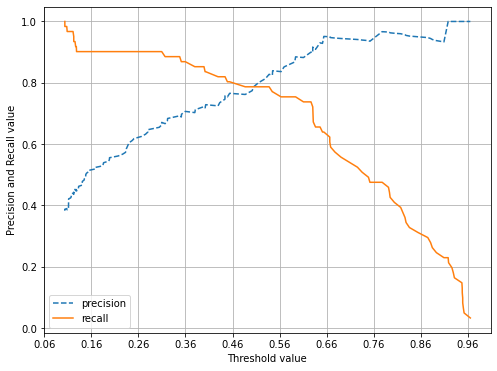

In [31]:
precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:, 1])

## F1 Score

$F1=\frac{2}{\frac{1}{recall}+\frac{1}{precision}}=2*\frac{precision*recall}{precision+recall}$

In [32]:
from sklearn.metrics import f1_score

f1 = f1_score(y_test, pred)
print(f'{f1:.4f}')

0.7805


In [33]:
def get_clf_eval(y_test, pred):
    
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    
    print('오차 행렬')
    print(confusion)
    print(f'정확도: {accuracy:.4f}, 정밀도: {precision:.4f}, 재현율: {recall:.4f}, f1: {f1:.4f}')

In [35]:
thresholds = [0.4, 0.45, 0.50, 0.55, 0.60]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1, 1), thresholds)

임계값: 0.4
오차 행렬
[[98 20]
 [10 51]]
정확도: 0.8324, 정밀도: 0.7183, 재현율: 0.8361, f1: 0.7727
임계값: 0.45
오차 행렬
[[103  15]
 [ 12  49]]
정확도: 0.8492, 정밀도: 0.7656, 재현율: 0.8033, f1: 0.7840
임계값: 0.5
오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869, f1: 0.7805
임계값: 0.55
오차 행렬
[[109   9]
 [ 15  46]]
정확도: 0.8659, 정밀도: 0.8364, 재현율: 0.7541, f1: 0.7931
임계값: 0.6
오차 행렬
[[112   6]
 [ 16  45]]
정확도: 0.8771, 정밀도: 0.8824, 재현율: 0.7377, f1: 0.8036


## ROC Curve, AUC

- 민감도(TPR)
 - 실제값 Positive가 정확히 예측돼야 하는 수준(질병이 있는 사람은 질병이 있는 것으로 양성 판정)
- 특이성(TNR)
 - 실제값 Negative가 정확히 예측돼야 하는 수준(질병이 없는 사람은 질병이 없는 것으로 음성 판정)
 - $TNR=\frac{TN}{FP+TN}$
 - $FPR=\frac{FP}{FP+TN}=1-TNR=1-특이성$

In [36]:
from sklearn.metrics import roc_curve

pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1]
fprs, tprs, thresholds = roc_curve(y_test, pred_proba_class1)

#thresholds[0]은 max(예측확률)+1로 임의 설정됨. 이를 제외하기 위해 np.arange는 1부터 시작
thr_index = np.arange(1, thresholds.shape[0], 5)
print('샘플 추출을 위한 임계값 배열의 index:', thr_index)
print('샘플 index로 추출한 임계값:', np.round(thresholds[thr_index], 2))
print('샘플 임계값 FPR:', np.round(fprs[thr_index], 3))
print('샘플 임계값 TPR:', np.round(tprs[thr_index], 3))

샘플 추출을 위한 임계값 배열의 index: [ 1  6 11 16 21 26 31 36 41 46 51]
샘플 index로 추출한 임계값: [0.97 0.65 0.63 0.56 0.45 0.4  0.35 0.15 0.13 0.11 0.11]
샘플 임계값 FPR: [0.    0.017 0.034 0.076 0.127 0.169 0.203 0.466 0.585 0.686 0.797]
샘플 임계값 TPR: [0.033 0.639 0.721 0.754 0.803 0.836 0.885 0.902 0.934 0.967 0.984]


In [37]:
def roc_curve_plot(y_test, pred_proba_c1):
    fprs, tprs, thresholds = roc_curve(y_test, pred_proba_c1)

    plt.plot(fprs, tprs, label='ROC')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel('FPR( 1 - Sensitivity )')
    plt.ylabel('TPR( Recall )')
    plt.legend()

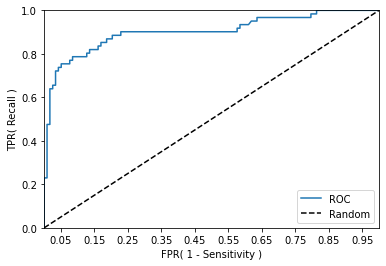

In [38]:
roc_curve_plot(y_test, pred_proba[:, 1])

In [39]:
from sklearn.metrics import roc_auc_score

pred_proba = lr_clf.predict_proba(X_test)[:, 1]
roc_score = roc_auc_score(y_test, pred_proba)
print(f'AUC: {roc_score}')

AUC: 0.9025423728813561


In [40]:
def get_clf_eval(y_test, pred=None, pred_proba=None):
    
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)
    
    print('오차 행렬')
    print(confusion)
    print(f'정확도: {accuracy:.4f}, 정밀도: {precision:.4f}, 재현율: {recall:.4f}, F1: {f1:.4f}, AUC: {roc_auc:.4f}')

In [41]:
get_clf_eval(y_test, pred, pred_proba)

오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869, F1: 0.7805, AUC: 0.9025
